In [ ]:
import pandas as pd
import numpy as np
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
match_1 = pd.read_json('/content/drive/MyDrive/footbar/match_1.json')
match_2 = pd.read_json('/content/drive/MyDrive/footbar/match_2.json')
match_concat = pd.concat([match_1, match_2], ignore_index=True)

# Exploratory Data Analysis

To explore the differences between the actions, we try to calculate the duration of each one, and some stastics of the acceleration (min, max, mean, median and standard deviation).

In [ ]:
match_concat['gait_duration'] = match_concat['norm'].apply(len)*0.02
match_concat['gait_mean'] = match_concat['norm'].apply(np.mean)
match_concat['gait_min'] = match_concat['norm'].apply(np.min)
match_concat['gait_max'] = match_concat['norm'].apply(np.max)
match_concat['gait_median'] = match_concat['norm'].apply(np.median)
match_concat['gait_std'] = match_concat['norm'].apply(np.std)
match_concat

,label,norm,gait_duration,gait_mean,gait_min,gait_max,gait_median,gait_std
0,walk,"[23.177037336396975, 23.361525285249378, 21.53...",1.44,24.166958,15.392703,42.738486,22.417711,5.965416
1,walk,"[20.998214383911275, 19.182798059840767, 18.27...",1.08,26.026276,15.520896,53.767061,22.864346,8.479134
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554...",1.36,23.998177,14.484489,42.105998,21.584619,6.328823
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787...",1.50,22.596573,14.867721,47.934160,20.998214,5.545197
4,rest,"[22.069263037713093, 19.672270483203395, 19.88...",3.62,20.378778,17.789805,22.069263,20.509409,0.739506
...,...,...,...,...,...,...,...,...
1182,walk,"[23.337305769963503, 20.210987911153104, 25.06...",1.04,29.107628,11.190245,65.462316,24.723429,10.920141
1183,walk,"[22.470322813933603, 22.552427730975246, 23.84...",1.28,26.673605,11.657530,51.724442,23.684421,8.728731
1184,walk,"[43.833612705797144, 46.18045998580312, 37.492...",1.20,28.842287,15.539368,89.365797,23.424746,12.171922
1185,walk,"[30.927599255773355, 31.26358258808756, 28.286...",1.32,25.121496,7.309930,71.505826,23.016231,9.942930


### Number of occurrences by action



In [ ]:
match_concat.label.value_counts(normalize=True)

run          0.465038
walk         0.366470
dribble      0.065712
rest         0.029486
pass         0.026959
tackle       0.026116
shot         0.015164
cross        0.003370
no action    0.001685
Name: label, dtype: float64

The "run" and "walk" actions are the most common. This gives us an idea of the distribution of the action in a match. A match is made up of more than 50% of "run" and "walk" actions.

In [ ]:
match_concat_count = match_concat.groupby("label",as_index=False).count().rename(columns={"norm":"count"})
fig = px.bar(match_concat_count, x='count', y='label', title = "Number of occurrences by action")
fig.update_layout(title_x=0.5)
fig.show()

### Max acceleration by action

In [ ]:
match_concat_fig = match_concat.copy()
match_concat_fig['lenght'] = match_concat_fig['norm'].apply(len)
match_concat_fig['mean'] = match_concat_fig['norm'].apply(np.mean)
match_concat_fig['max'] = match_concat_fig['norm'].apply(np.max)

In [ ]:
fig = px.histogram(match_concat_fig, x="max", color="label", title = "Distrubtion of max acceleration by action")
fig.update_layout(title_x=0.5)
fig.show()

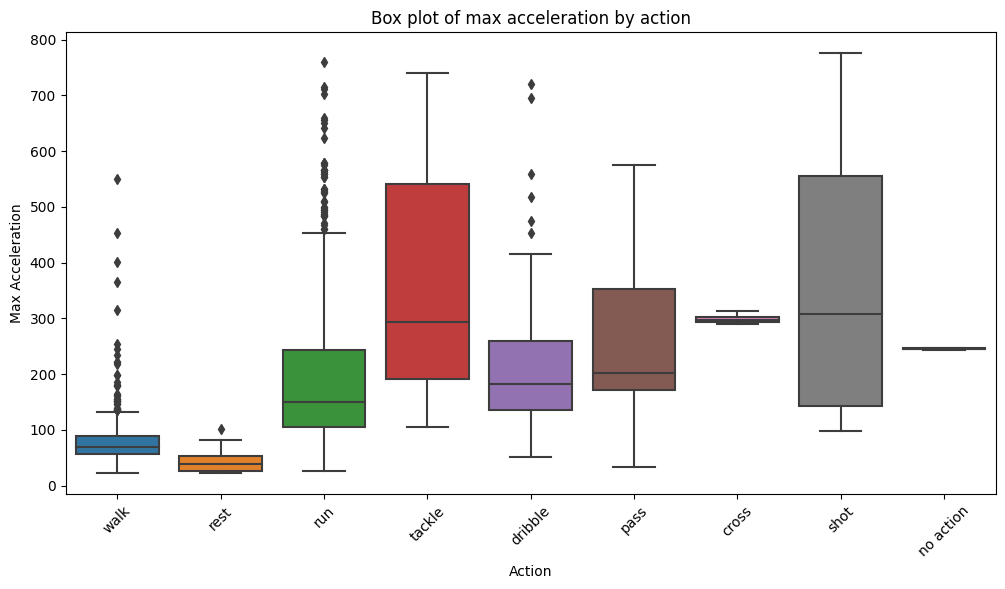

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='gait_max', data=match_concat)
plt.xticks(rotation=45)
plt.title('Box plot of max acceleration by action')
plt.xlabel('Action')
plt.ylabel('Max Acceleration')
plt.show()

The "run", "tackle", "pass" and "shot" actions have the highest maximum accelerations. We also notice that these maximum accelerations vary a lot in the "tackle" and "shot" actions and remain in a very small range for the "cross" action.

### Mean accelation by action

In [ ]:
fig = px.histogram(match_concat_fig, x="mean", color="label", title = "Distrubtion of mean acceleration by action")
fig.update_layout(title_x=0.5)
fig.show()

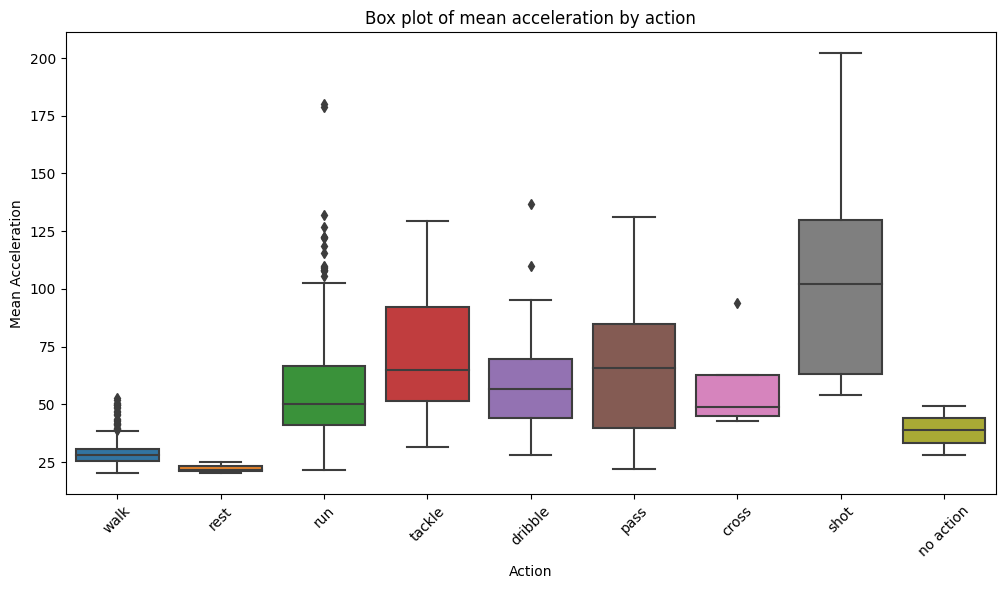

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='gait_mean', data=match_concat)
plt.xticks(rotation=45)
plt.title('Box plot of mean acceleration by action')
plt.xlabel('Action')
plt.ylabel('Mean Acceleration')
plt.show()

### The length (duration) of each action

In [ ]:
fig = px.histogram(match_concat_fig, x="lenght", color="label", title="Distrubtion of the length of each action")
fig.update_layout(title_x=0.5)
fig.show()

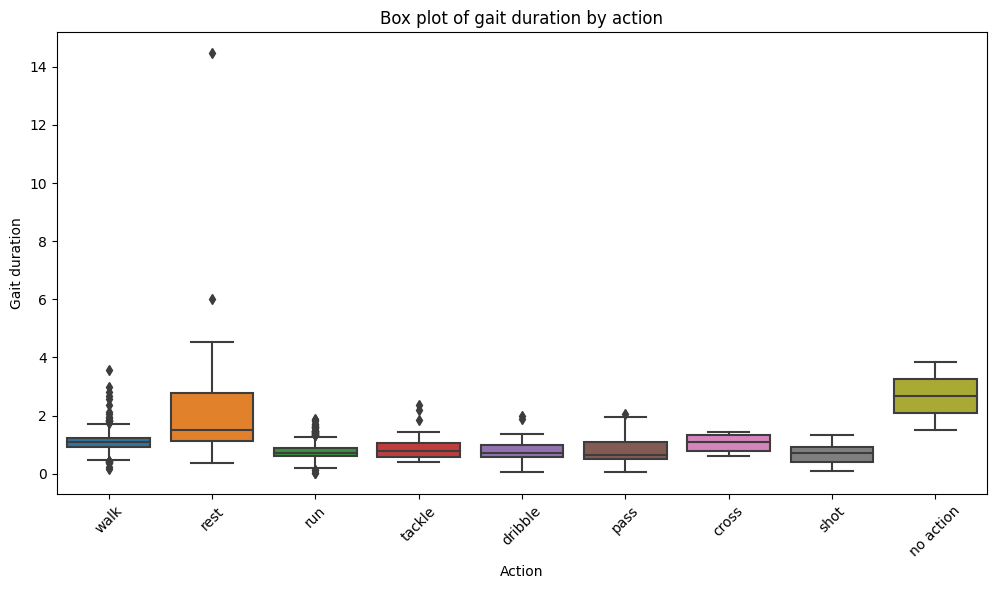

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='gait_duration', data=match_concat)
plt.xticks(rotation=45)
plt.title('Box plot of gait duration by action')
plt.xlabel('Action')
plt.ylabel('Gait duration')
plt.show()

The 'rest' action takes much longer than the other actions, whereas the 'run' action takes less time, which can be justified by the fact that a player can't run for long at high speed.

# Modelling

### Preprocessing

In [ ]:
match_concat.describe(percentiles=[.005, .5, .75, .95, .98])

,gait_duration,gait_mean,gait_min,gait_max,gait_median,gait_std
count,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000
mean,0.941078,46.346373,14.069531,159.543627,39.056835,28.856896
std,0.608432,23.797832,6.949747,135.354562,18.236281,26.066746
min,0.020000,20.099577,1.674630,22.069263,19.813333,0.000000
0.5%,0.117200,20.752886,2.963342,24.132508,20.125685,1.220710
50%,0.880000,39.166649,13.086243,110.724715,33.258858,20.369153
75%,1.120000,57.413722,16.624149,192.319937,48.782934,35.432828
95%,1.560000,92.127656,27.779731,489.743240,73.469392,87.427489
98%,2.040000,109.257965,34.302708,566.523943,85.636106,112.244759
max,14.460000,202.130400,65.472226,775.479360,165.179490,199.964277


In [ ]:
#List of all actions
actions = list(np.unique(match_concat.label.values))

In [ ]:
#Dictionnary of dataframes of all actions
dict_data = {}
for action in actions:
  index_action = list((match_concat['label'] == action)[match_concat['label'] == action].index)
  dict_data[f'data_{action}'] = match_concat.loc[index_action]

In [ ]:
for action in actions:
  print(action, dict_data[f'data_{action}']['gait_duration'].min(), dict_data[f'data_{action}']['gait_duration'].median(), dict_data[f'data_{action}']['gait_duration'].mean(), dict_data[f'data_{action}']['gait_duration'].max())

cross 0.6 1.08 1.0499999999999998 1.44
dribble 0.06 0.72 0.7851282051282051 2.0
no action 1.52 2.6799999999999997 2.6799999999999997 3.84
pass 0.06 0.66 0.85375 2.04
rest 0.36 1.52 2.3154285714285714 14.46
run 0.02 0.7000000000000001 0.7531521739130435 1.8800000000000001
shot 0.08 0.72 0.6755555555555555 1.32
tackle 0.4 0.8 0.9245161290322581 2.36
walk 0.16 1.08 1.106528735632184 3.58


To ensure a logical length of the gaits, we have set a minimum and maximum logic for each type of action.

In [ ]:
#Dictionnary of [min, max] length of each action
dict_action_length = {}

dict_action_length['no action'] = [0.4, 3]
dict_action_length['rest'] = [0.4, 3]
dict_action_length['cross'] = [0.4, 3]
dict_action_length['walk'] = [0.4, 3]

dict_action_length['dribble'] = [0.1, 1.4]
dict_action_length['shot'] = [0.1, 1.4]

dict_action_length['pass'] = [0.1, 2.3]
dict_action_length['tackle'] = [0.1, 2.3]
dict_action_length['run'] = [0.1, 2.3]


In [ ]:
def valid_gait(data_frame, action):
  """
    Filter a DataFrame based on the duration of a specific gait action.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame containing gait data.
    - action (str): The gait action for which to filter the data.

    Returns:
    - pd.DataFrame: A filtered DataFrame containing only rows where the gait duration falls within the specified range for the given action.

    This function filters the input DataFrame based on the duration of a specific gait action,
    ensuring that the gait duration falls within a predefined range for that action (predefined length).
    The 'action' parameter specifies which gait action to filter, and the function uses the
    'dict_action_length' dictionary to determine the allowable duration range for that action.
    """
  min = dict_action_length[action][0]
  max = dict_action_length[action][1]

  mask_min = (data_frame.gait_duration > min)
  mask_max = (data_frame.gait_duration < max)
  mask = np.logical_and(mask_min, mask_max)

  v_gait = list(mask[mask].index)

  return data_frame.loc[v_gait].reset_index(drop=True)

We keep only gaits that respect the [min,max] length fixed above

In [ ]:
dict_data_valid = {}
for action in actions :
  dict_data_valid[f'data_valid_{action}'] = valid_gait(dict_data[f'data_{action}'], action)

To train our model, we should have the same length for all gaits of each action, so we should impute gaits with a length lower than the maximal length. In order to keep the same distrubtion for all gaits, we use the normal distrubtion of the gait. The numbers generated must be between the min and the max acceleration of the gait.

In [ ]:
def impute_with_normal_distribution(x, length):
    """
    Impute missing values in a list 'x' using the normal distribution of the list "x".

    Parameters:
    - x (list): The list containing numeric values.
    - length (int): The length of "x" after the imputation.

    Returns:
    - list: A new list with the choosen length imputed using random values drawn from the normal distribution of the initial list "x".

    This function imputes the list 'x' to reach a choosen length : 'length' random values from
    a normal distribution with the same mean and standard deviation as in 'x'. Those values are beetween
    the min and the max of "x"
    The imputed values are added to the end of the list 'x'.
    """

    for i in range(length):
      bool = True
      while bool:
          random_value = np.random.normal(np.mean(x), np.std(x))
          if np.min(x) <= random_value <= np.max(x):
              x.append(random_value)
              bool = False

    return x

In [ ]:
for action in actions:
  dict_data_valid[f'data_valid_{action}']['norm'].apply(lambda x : impute_with_normal_distribution(x, int(dict_action_length[action][1]/0.02) - len(x)))

The gaits are transformed into columns so that each column contains an acceleration.

In [ ]:
dict_data_modelling = {}
for action in actions :
  dict_data_modelling[f'data_modelling_{action}'] = dict_data_valid[f'data_valid_{action}'].copy()
  for i in range(int(dict_action_length[action][1]*50)):
    dict_data_modelling[f'data_modelling_{action}'][f'element_{i}']= dict_data_modelling[f'data_modelling_{action}']['norm'].apply(lambda x: x[i])
  dict_data_modelling[f'data_modelling_{action}'] = dict_data_modelling[f'data_modelling_{action}'].drop(columns = ['norm','gait_duration','gait_min', 'gait_mean', 'gait_max','gait_median','gait_std'])

### Model training

We have only one row for the action "no action", so we don't use it for the model training

In [ ]:
actions = ['cross',
 'dribble',
 'pass',
 'rest',
 'run',
 'shot',
 'tackle',
 'walk']

We train one CTGAN model for each action, for more details check the pdf.

In [ ]:
dict_metadata = {}
dict_synthesizer = {}
for action in actions :
  dict_metadata[f'metadata_{action}'] = SingleTableMetadata()
  dict_metadata[f'metadata_{action}'].detect_from_dataframe(data=dict_data_modelling[f'data_modelling_{action}'])

  dict_synthesizer[f'synth_{action}'] = CTGANSynthesizer(
    dict_metadata[f'metadata_{action}'],
    enforce_min_max_values=True,
    enforce_rounding=False,
    )

  dict_synthesizer[f'synth_{action}'].fit(dict_data_modelling[f'data_modelling_{action}'])



In [ ]:
for action in actions:

  dict_synthesizer[f'synth_{action}'].save(
    filepath='/content/drive/MyDrive/footbar/' + f'synth_{action}.pkl'
)


In [ ]:
dict_synthesizer = {}
for action in actions:
  dict_synthesizer[f'synth_{action}'] = CTGANSynthesizer.load(
      filepath='/content/drive/MyDrive/footbar/' + f'synth_{action}.pkl'
  )

# Match generation

In [49]:
def gen_match(time, style):
  """
    Generate a synthetic football match dataset based on the specified time and playing style.

    Parameters:
    - time (float): The duration of the football match in minutes.
    - style (str): The playing style of the match, which can be 'attacking', 'defending', or 'balanced'.

    Returns:
    - pd.DataFrame: A synthetic football match dataset with actions. Each row contain an gait of action and the label of this action

    This function generates a synthetic football match dataset with actions such as 'walk', 'run', 'rest', 'dribble', 'cross', 'pass', 'shot', and 'tackle'.
    The probabilities of these actions occurring are determined by the playing style specified:
    - 'attacking': Actions with higher offensive probabilities.
    - 'defending': Actions with higher defensive probabilities.
    - 'balanced': Actions with balanced probabilities.

    The 'time' parameter specifies the duration of the match in minutes, which is converted to seconds internally.

    The generated dataset includes action labels and 'norm' columns containing synthetic data for each action.
    The data is sampled and shuffled to create a realistic match sequence and is returned as a Pandas DataFrame.
    """
  dict_match = {}
  if style == 'attacking':
        action_probs = {'walk': 0.2, 'run': 0.3, 'rest': 0.04, 'dribble': 0.15, 'cross': 0.1, 'pass': 0.1, 'shot': 0.1, 'tackle': 0.01}
  elif style == 'defending':
      action_probs = {'walk': 0.2, 'run': 0.3, 'rest': 0.05, 'dribble': 0.14, 'cross': 0.05, 'pass': 0.05, 'shot':0.01, 'tackle': 0.2}
  elif style == 'balanced':
      action_probs = {'walk': 0.2, 'run': 0.3, 'rest': 0.05, 'dribble': 0.1, 'cross': 0.15, 'pass': 0.15, 'shot': 0.1, 'tackle':0.1}

  time = time*60

  action_in_game = []
  for action in actions:
    dict_match[f'match_{action}'] = dict_synthesizer[f'synth_{action}'].sample(num_rows = int(time*action_probs[action]/dict_action_length[action][1])-1)
    if dict_match[f'match_{action}'].shape[0] != 0:
        action_in_game.append(action)
        dict_match[f'match_{action}']['norm'] = dict_match[f'match_{action}'].drop(columns=['label']).apply(lambda row: row.tolist(), axis=1)

  data_match = pd.concat([dict_match[f'match_{action}'] for action in action_in_game], axis = 0)

  bool = True
  while bool:
    real_match = data_match[['label','norm']].sample(frac=1).reset_index(drop=True)
    pattern = ['shot','shot','shot']
    for i in range(len(list(real_match['label'])) - len(pattern) + 1):
        if list(real_match['label'])[i:i+len(pattern)] == pattern:
          bool = False

  return real_match

In [50]:
match = gen_match(15, 'attacking')

In [52]:
match

,label,norm
0,run,"[78.68644987219756, 80.07343677974353, 65.9581..."
1,dribble,"[9.884389166881045, 73.63227517393656, 62.4231..."
2,run,"[88.6284773002977, 109.88322517389064, 60.0405..."
3,dribble,"[9.884389166881045, 115.81641753792961, 27.515..."
4,run,"[77.85027429427358, 76.12853436795524, 157.875..."
...,...,...
408,dribble,"[9.884389166881045, 86.54166168889421, 74.7516..."
409,walk,"[22.59198720842708, 54.99342238812733, 21.3426..."
410,shot,"[13.40051035824778, 60.18165079490617, 150.650..."
411,run,"[42.87584078368021, 59.03519942041823, 46.6802..."
